In [1]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from scipy.linalg import toeplitz

from sklearn.linear_model import RidgeCV



def ind(i,j,k):
    # separates &,n into k blocks
    return int(i//k==j//k)
# One Toeplitz matrix  
def toep (d, rho=0.6):
  return np.array([[ (rho)**abs(i-j) for i in range(d)]for j in range(d)])


def simu_data(n, p, rho=0.25, snr=2.0, sparsity=0.06, effect=1.0, seed=None):
    # Setup seed generator
    rng = np.random.default_rng(seed)

    # Number of non-null
    k = int(sparsity * p)

    # Generate the variables from a multivariate normal distribution
    mu = np.zeros(p)
    Sigma = toeplitz(rho ** np.arange(0, p))  # covariance matrix of X
    # X = np.dot(np.random.normal(size=(n, p)), cholesky(Sigma))
    X = rng.multivariate_normal(mu, Sigma, size=(n))
    # Generate the response from a linear model
    blob_indexes = np.linspace(0, p - 6, int(k/5), dtype=int)
    non_zero = np.array([np.arange(i, i+5) for i in blob_indexes])
    # non_zero = rng.choice(p, k, replace=False)
    beta_true = np.zeros(p)
    beta_true[non_zero] = effect
    eps = rng.standard_normal(size=n)
    prod_temp = np.dot(X, beta_true)
    noise_mag = np.linalg.norm(prod_temp) / (snr * np.linalg.norm(eps))
    y = prod_temp + noise_mag * eps

    return X, y, beta_true, non_zero, Sigma



def GenToysDataset(n=1000, d=10, cor='toep', y_method="nonlin", k=2, mu=None, rho_toep=0.6, sparsity=0.1, seed=0, snr=2):
    """
    Generate a synthetic toy dataset for regression tasks.

    Parameters:
    -----------
    n : int, optional (default=1000)
        Number of samples.
    d : int, optional (default=10)
        Number of features.
    cor : str, optional (default='toep')
        Type of correlation among features. Options:
        - 'iso': Isotropic normal distribution.
        - 'cor': Correlated features using matrix U.
        - 'toep': Toeplitz covariance structure.
    y_method : str, optional (default='nonlin')
        Method for generating target variable y. Options:
        - 'williamson': Quadratic function of first two features.
        - 'hidimstats': High-dimensional sparse regression.
        - 'nonlin': Nonlinear interaction of first five features.
        - 'nonlin2': Extended nonlinear interactions with additional terms.
        - 'lin': Linear combination of first two features.
        - 'poly': Polynomial interactions of randomly selected features.
    k : int, optional (default=2)
        Parameter for correlation matrix U when cor='cor'.
    mu : array-like or None, optional (default=None)
        Mean vector for multivariate normal distribution.
    rho_toep : float, optional (default=0.6)
        Correlation coefficient for Toeplitz covariance matrix.
    sparsity : float, optional (default=0.1)
        Proportion of nonzero coefficients in high-dimensional regression.
    seed : int, optional (default=0)
        Random seed for reproducibility.
    snr : float, optional (default=2)
        Signal-to-noise ratio for high-dimensional regression.

    Returns:
    --------
    X : ndarray of shape (n, d)
        Feature matrix.
    y : ndarray of shape (n,)
        Target variable.
    true_imp : ndarray of shape (d,)
        Binary array indicating which features are truly important.
    """
    np.random.seed(seed)
    true_imp = np.zeros(d)
    
    if y_method == "williamson":
        X1, X2 = np.random.uniform(-1, 1, (2, n))
        X = np.column_stack((X1, X2))
        y = (25/9) * X1**2 + np.random.normal(0, 1, n)
        return X, y, np.array([1, 0])
    
    if y_method == "hidimstats":
        X, y, _, non_zero_index, _ = simu_data(n, d, rho=rho_toep, sparsity=sparsity, seed=seed, snr=snr)
        true_imp[non_zero_index] = 1
        return X, y, true_imp
    
    mu = np.zeros(d) if mu is None else mu
    X = np.zeros((n, d))
    
    if cor == 'iso':
        X = np.random.normal(size=(n, d))
    elif cor == 'cor':
        U = np.array([[ind(i, j, k) for j in range(d)] for i in range(d)]) / np.sqrt(k)
        X = np.random.normal(size=(n, d)) @ U + mu
    elif cor == 'toep':
        X = np.random.multivariate_normal(mu, toep(d, rho_toep), size=n)
    else:
        raise ValueError("Invalid correlation type. Choose from 'iso', 'cor', or 'toep'.")
    
    if y_method == "nonlin":
        y = X[:, 0] * X[:, 1] * (X[:, 2] > 0) + 2 * X[:, 3] * X[:, 4] * (X[:, 2] <= 0)
        true_imp[:5] = 1
    elif y_method == "nonlin2":
        y = (X[:, 0] * X[:, 1] * (X[:, 2] > 0) + 2 * X[:, 3] * X[:, 4] * (X[:, 2] <= 0)
             + X[:, 5] * X[:, 6] / 2 - X[:, 7]**2 + X[:, 9] * (X[:, 8] > 0))
        true_imp[:10] = 1
    elif y_method == "lin":
        y = 2 * X[:, 0] + X[:, 1]
        true_imp[:2] = 1
    elif y_method == "poly":
        rng = np.random.RandomState(seed)
        non_zero_index = rng.choice(d, int(sparsity * d), replace=False)
        poly_transformer = PolynomialFeatures(degree=3, interaction_only=True)
        features = poly_transformer.fit_transform(X[:, non_zero_index])
        coef_features = np.random.choice([-1, 1], features.shape[1])
        y = np.dot(features, coef_features)
        true_imp[non_zero_index] = 1
    else:
        raise ValueError("Invalid y_method. Choose from 'williamson', 'hidimstats', 'nonlin', 'nonlin2', 'lin', or 'poly'.")
    
    return X, y, true_imp

In [2]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from sklearn.base import BaseEstimator, check_is_fitted, clone
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import os, sys
sys.path.append(os.path.abspath(os.path.join("..", "src")))

from utils import knockoff_threshold
from scipy.stats import wilcoxon
import random
from scipy.stats import binomtest

class CPI_KO(BaseEstimator):
    """
    Sobol Conditional Permutation Importance (CPI) algorithm.
    :footcite:t:`

    Parameters
    ----------
    estimator: scikit-learn compatible estimator
        The predictive model.
    imputation_model: scikit-learn compatible estimator or list of estimators
        The model(s) used to estimate the covariates. If a single estimator is
        provided, it will be cloned for each covariate group. Otherwise, a list of
        potentially different estimators can be provided, the length of the
        list must match the number of covariate groups.
    n_permutations: int, default=50
        Number of permutations to perform.
    loss: callable, default=root_mean_squared_error
        Loss function to evaluate the model performance.
    score_proba: bool, default=False
        Whether to use the predict_proba method of the estimator.
    random_state: int, default=None
        Random seed for the permutation.
    n_jobs: int, default=1
        Number of jobs to run in parallel.

    References
    ----------
    .. footbibliography::
    
    """

    def __init__(
        self,
        estimator,
        imputation_model,
        imputation_model_y,
        loss: callable = mean_squared_error,
        score_proba: bool = False,
        random_state: int = None,
        n_jobs: int = 1,
    ):

        check_is_fitted(estimator)
        self.estimator = estimator
        self.imputation_model = imputation_model
        self.imputation_model_y = imputation_model_y
        self.random_state = random_state
        self.loss = loss
        self.score_proba = score_proba
        self.n_jobs = n_jobs
        self.rng = np.random.RandomState(random_state)

    def fit(self, X, y=None, groups=None):
        """
        Fit the covariate estimators to predict each group of covariates from
        the others.

        Parameters
        ----------
        X: np.ndarray of shape (n_samples, n_features)
            The input samples. If groups is provided, the columns must correspond to
            the values of the groups dictionary.
        y: np.ndarray of shape (n_samples,)
            The target values. Not used in the fitting of the covariate estimators.
        groups: dict, default=None
            Dictionary of groups for the covariates. The keys are the group names
            and the values are lists of covariate indices.
        """
        self.groups = groups
        if isinstance(self.imputation_model, list):
            self._list_imputation_models = self.imputation_model
        else:
            self._list_imputation_models = []
        if isinstance(self.imputation_model_y, list):
            self._list_imputation_models_y = self.imputation_model_y
        else:
            self._list_imputation_models_y = []

        if self.groups is None:
            self.n_groups = X.shape[1]
            self.groups = {j: [j] for j in range(self.n_groups)}
        else:
            self.n_groups = len(self.groups)
        # create a list of covariate estimators for each group if not provided
        if len(self._list_imputation_models) == 0:
            self._list_imputation_models = [
                clone(self.imputation_model) for _ in range(self.n_groups)
            ]
        if len(self._list_imputation_models_y) == 0:
            self._list_imputation_models_y = [
                clone(self.imputation_model_y) for _ in range(self.n_groups)
            ]
        def _joblib_fit_one_group(estimator, X, y, j):
            """
            Fit a single covariate estimator to predict a single group of
            covariates.
            """
            if isinstance(X, pd.DataFrame):
                X_j = X[self.groups[j]].copy().values
                X_minus_j = X.drop(columns=self.groups[j]).values
            else:
                X_j = X[:, self.groups[j]].copy()
                if X_j.shape[1]==1:
                    X_j = X_j.ravel()
                X_minus_j = np.delete(X, self.groups[j], axis=1)
            estimator.fit(X_minus_j, X_j)
            return estimator
        
        def _joblib_fit_one_group_y(estimator, X, y, j):
            """
            Fit a single covariate estimator to predict a single group of
            covariates.
            """
            if isinstance(X, pd.DataFrame):
                X_j = X[self.groups[j]].copy().values
                X_minus_j = X.drop(columns=self.groups[j]).copy()
                # append y as a new column
                X_minus_j["y"] = y
                X_minus_j = X_minus_j.values
            else:
                X_j = X[:, self.groups[j]].copy()
                if X_j.shape[1] == 1:
                    X_j = X_j.ravel()
                X_minus_j = np.delete(X, self.groups[j], axis=1)
                # append y as last column
                X_minus_j = np.column_stack((X_minus_j, y))
            estimator.fit(X_minus_j, X_j)
            return estimator
        

        # Parallelize the fitting of the covariate estimators
        self._list_imputation_models = Parallel(n_jobs=self.n_jobs)(
            delayed(_joblib_fit_one_group)(estimator, X, y, j)
            for j, estimator in zip(self.groups.keys(), self._list_imputation_models)
        )

        self._list_imputation_models_y = Parallel(n_jobs=self.n_jobs)(
            delayed(_joblib_fit_one_group_y)(estimator, X, y, j)
            for j, estimator in zip(self.groups.keys(), self._list_imputation_models_y)
        )

        return self

    def predict(self, X, y, n_perm):
        """
        Compute the prediction of the model with perturbed data for each group.
        For each group of covariates, the residuals are computed using the
        covariate estimators. The residuals are then permuted and the model is
        re-evaluated n_cal times. Then, the mean is taken over the predictions.

        Parameters
        ----------
        X: array-like of shape (n_samples, n_features)
            The input samples.
        y: array-like of shape (n_samples,)
            The target values.
        n_cal: int, default=10
            Number of perturbed predictions for each sample.

        Returns
        -------
        residual_permuted_y_pred: np.ndarray of shape (n_groups, n_permutations, n_samples)
            The predictions of the model averaged over n_cal conditional permutation for each group
        """
        if len(self._list_imputation_models) == 0:
            raise ValueError("fit must be called before predict")
        for m in self._list_imputation_models:
            check_is_fitted(m)

        def _joblib_predict_one_group(imputation_model, X, j, n_perm):
            """
            Compute n_perm predictions of the model with the permuted data for a
            single group of covariates.
            """
            list_y_pred_perm = []
            if isinstance(X, pd.DataFrame):
                X_j = X[self.groups[j]].copy().values
                X_minus_j = X.drop(columns=self.groups[j]).values
                group_ids = [
                    i for i, col in enumerate(X.columns) if col in self.groups[j]
                ]
                non_group_ids = [
                    i for i, col in enumerate(X.columns) if col not in self.groups[j]
                ]
            else:
                X_j = X[:, self.groups[j]].copy()
                X_minus_j = np.delete(X, self.groups[j], axis=1)
                group_ids = self.groups[j]
                non_group_ids = np.delete(np.arange(X.shape[1]), group_ids)
            X_j_hat = imputation_model.predict(X_minus_j).reshape(X_j.shape)
            residual_j = X_j - X_j_hat

            for _ in range(n_perm):
                y_pred_perm = np.zeros(X.shape[0])
                X_j_perm = X_j_hat + self.rng.permutation(residual_j)
                X_perm = np.empty_like(X)
                X_perm[:, non_group_ids] = X_minus_j
                X_perm[:, group_ids] = X_j_perm
                if isinstance(X, pd.DataFrame):
                    X_perm = pd.DataFrame(X_perm, columns=X.columns)

                if self.score_proba:
                    y_pred_perm += self.estimator.predict_proba(X_perm)
                else:
                    y_pred_perm += self.estimator.predict(X_perm)
                list_y_pred_perm.append(y_pred_perm)

            return np.array(list_y_pred_perm)
        
        def _joblib_predict_one_group_y(imputation_model, X, y, j, n_perm):
            """
            Compute n_perm predictions of the model with the permuted data for a
            single group of covariates.
            """
            list_y_pred_perm = []

            if isinstance(X, pd.DataFrame):
                X_j = X[self.groups[j]].copy().values
                X_minus_j = X.drop(columns=self.groups[j]).copy()
                X_minus_j["y"] = y
                X_minus_j = X_minus_j.values
                group_ids = [
                    i for i, col in enumerate(X.columns) if col in self.groups[j]
                ]
                non_group_ids = [
                    i for i, col in enumerate(X.columns) if col not in self.groups[j]
                ]
            else:
                X_j = X[:, self.groups[j]].copy()
                X_minus_j = np.delete(X, self.groups[j], axis=1)
                X_minus_j_y = np.column_stack((X_minus_j, y))
                group_ids = self.groups[j]
                non_group_ids = np.delete(np.arange(X.shape[1]), group_ids)
            X_j_hat = imputation_model.predict(X_minus_j_y).reshape(X_j.shape)
            residual_j = X_j - X_j_hat

            for _ in range(n_perm):
                y_pred_perm = np.zeros(X.shape[0])
                X_j_perm = X_j_hat + self.rng.permutation(residual_j)
                X_perm = np.empty_like(X)
                X_perm[:, non_group_ids] = X_minus_j
                X_perm[:, group_ids] = X_j_perm
                if isinstance(X, pd.DataFrame):
                    X_perm = pd.DataFrame(X_perm, columns=X.columns)

                if self.score_proba:
                    y_pred_perm += self.estimator.predict_proba(X_perm)
                else:
                    y_pred_perm += self.estimator.predict(X_perm)
                list_y_pred_perm.append(y_pred_perm)

            return np.array(list_y_pred_perm)


     # Parallelize the computation of the importance scores for each group
        out_list = Parallel(n_jobs=self.n_jobs)(
            delayed(_joblib_predict_one_group)(imputation_model, X, j, n_perm)
            for j, imputation_model in zip(
                self.groups.keys(), self._list_imputation_models
            )
        )

        residual_permuted_y_pred = np.stack(out_list, axis=0)

        out_list_y = Parallel(n_jobs=self.n_jobs)(
            delayed(_joblib_predict_one_group_y)(imputation_model, X, y, j, n_perm)
            for j, imputation_model in zip(
                self.groups.keys(), self._list_imputation_models_y
            )
        )

        residual_permuted_y_pred_y = np.stack(out_list_y, axis=0)

        return residual_permuted_y_pred, residual_permuted_y_pred_y

    def score(self, X, y, p_val='wilcox', n_perm=1, fdr=0.1):
        """
        Compute the importance scores and p-values for each group of covariates.

        Parameters
        ----------
        X: array-like of shape (n_samples, n_features)
            The input samples.
        y: array-like of shape (n_samples,)
            The target values.
        n_cal: int, default=10
            Calibration set size.
        p_val: {'emp_var', 'corrected_sqrt', 'corrected_n', 'corrected_sqd'}, optional
            Method used to compute the p-value:
            - 'emp_var': not corrected term, and if divides by 0 then p-value=1.
            - 'corrected_sqrt': Corrects the variance by adding var(y)/n**0.5.
            - 'corrected_n': Corrects the variance by adding var(y)/n.
            - 'corrected_sqd': Corrects the variance by adding var(y)/n**2.
        bootstrap: bool, default=False
            If True, variance estimated with bootstrap, otherwise accross individuals.

        Returns
        -------
        out_dict: dict
            A dictionary containing the following keys:
            - 'loss_reference': the loss of the model with the original data.
            - 'loss_perm': a dictionary containing the loss of the model with
            the permuted data for each group.
            - 'importance': the importance scores for each group (estimated Total Sobol Index).
            - 'pval': the p-value.
            - 'std': standard deviation.
        """
        check_is_fitted(self.estimator)
        if len(self._list_imputation_models) == 0:
            raise ValueError("fit must be called before score")
        for m in self._list_imputation_models:
            check_is_fitted(m)

        out_dict = dict()


        y_pred_perm, y_pred_perm_y = self.predict(X, y, n_perm)

        out_dict["loss_perm"] = dict()
        out_dict["loss_perm_y"] = dict()
        for j, (y_pred_j, y_pred_y_j) in enumerate(zip(y_pred_perm, y_pred_perm_y)):
            list_loss_perm = []
            list_loss_perm_y = []
            for y_pred_perm_j, y_pred_perm_y_j in zip(y_pred_j, y_pred_y_j):
                for n_t in range(y_pred_perm_j.shape[0]):
                    list_loss_perm.append(self.loss(y_true=np.array([y[n_t]]), y_pred=np.array([y_pred_perm_j[n_t]])))
                    list_loss_perm_y.append(self.loss(y_true=np.array([y[n_t]]), y_pred=np.array([y_pred_perm_y_j[n_t]])))

            out_dict["loss_perm"][j] = np.array(list_loss_perm)
            out_dict["loss_perm_y"][j] = np.array(list_loss_perm_y)



        out_dict["importance"] = np.array(
            [
                (np.mean(out_dict["loss_perm"][j])-np.mean(out_dict["loss_perm_y"][j]))
                for j in range(self.n_groups)
            ]
        )
       
        if p_val=='wilcox':
            p_value_=np.zeros(X.shape[1])
            for j in range(X.shape[1]):
                _, p_value_[j] = wilcoxon(out_dict["loss_perm"][j], out_dict["loss_perm_y"][j], alternative="greater")
            out_dict['pval']=p_value_
        elif p_val=='sign_test':
            p_value_=np.zeros(X.shape[1])
            for j in range(X.shape[1]):
                stat_sign_test = binomtest(np.sum( out_dict["loss_perm"][j] > out_dict["loss_perm_y"][j]), out_dict["loss_perm_y"][j].shape[0], alternative="greater")
                p_value_[j]=stat_sign_test.pvalue
            out_dict['pval']=p_value_
        elif p_val=='FDR':
            ko_thr = knockoff_threshold(out_dict["importance"], fdr=fdr)
            out_dict['selected']= np.where(out_dict["importance"] >= ko_thr)[0]
            

        return out_dict

In [3]:
def sample_X_j(X,j, rho=0.6, mu=None):
    Sigma_X = toeplitz(rho ** np.arange(0, X.shape[1])) 
    X_without_j = np.delete(X, j, axis=1)
    Sigma_without_j = np.delete(Sigma_X, j, axis=1)
    Sigma_without_jj = np.delete(Sigma_without_j, j, axis=0)
    if mu==None:
        mu = np.zeros(X.shape[1])
    mu_without_j = np.delete(mu, j)
    mu_cond = mu[j]+Sigma_without_j@np.linalg.inv(Sigma_without_jj)@(X_without_j-mu_without_j)
    sigma_cond = (
        Sigma_X[j, j]
        - Sigma_without_j[j, :]
        @ np.linalg.inv(Sigma_without_jj)
        @ Sigma_without_j[j, :].T
    )
    return np.random.multivariate_normal(mu_cond, sigma_cond)

def sample_Xy_j(X, Y, j, beta_true, rho=0.6, mu=None, seed=None, snr = 2):
    if abs(beta_true[j])<1e-3:#Null coordinate, independent of output
        return sample_X_j(X,j, rho=rho, mu=mu)
    X_without_j = np.delete(X, j, axis=1)
    beta_without_j = np.delete(beta_true, j)
    rng = np.random.default_rng(seed)
    eps = rng.standard_normal(size=X.shape[0])
    nu_j = (Y-np.dot(X_without_j, beta_without_j))/beta_true[j]
    prod_temp = np.dot(X_without_j, beta_without_j)
    noise_mag = np.linalg.norm(prod_temp) / (snr * np.linalg.norm(eps))
    return nu_j + noise_mag

In [4]:
import os, sys
sys.path.append(os.path.abspath(os.path.join("..", "src")))
from cpi_KO import CPI_KO
from sklearn.linear_model import LassoCV




n = 300
d = 50
sparsity = 0.25
seed = 0

n_jobs = 1


true_imp = np.zeros(d)
X, y, _, non_zero_index, _ = simu_data(n, d, rho=0.6, sparsity=sparsity, seed=seed)
true_imp[non_zero_index] = 1
model = LassoCV(alphas=np.logspace(-3, 3, 10), cv=5, random_state=seed)
model.fit(X, y)

cpi_knockoffs= CPI_KO(
                estimator=model,
                imputation_model=RidgeCV(alphas=np.logspace(-3, 3, 10), cv=5),
                imputation_model_y=RidgeCV(alphas=np.logspace(-3, 3, 10), cv=5),
                random_state=seed,
                n_jobs=n_jobs)
cpi_knockoffs.fit(X, y)

cpi_KO_importance = cpi_knockoffs.score(X, y, n_perm=1,  p_val='wilcox')


cpi_knockoffs_lasso= CPI_KO(
                estimator=model,
                imputation_model=LassoCV(alphas=np.logspace(-3, 3, 10), cv=5),
                imputation_model_y=LassoCV(alphas=np.logspace(-3, 3, 10), cv=5),
                random_state=seed,
                n_jobs=n_jobs)
cpi_knockoffs_lasso.fit(X, y)

cpi_KO_importance_lasso = cpi_knockoffs_lasso.score(X, y, n_perm=1,  p_val='wilcox')




/home/mind/areyerol/.local/miniconda3/lib/python3.12/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se
/home/mind/areyerol/.local/miniconda3/lib/python3.12/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se


In [5]:
def compute_norm_differences(list_X, list_Xy, d):
    diffs = []
    for j in range(d):
        beta1 = np.append(list_X[j].coef_, 0.0)  # (beta_X, 0)
        beta2 = list_Xy[j].coef_                 # (X^{-j}, y)
        diffs.append(np.linalg.norm(beta1 - beta2))
    return np.array(diffs)



In [6]:
list_X_ridge  = cpi_knockoffs._list_imputation_models
list_Xy_ridge = cpi_knockoffs._list_imputation_models_y

list_X_lasso  = cpi_knockoffs_lasso._list_imputation_models
list_Xy_lasso = cpi_knockoffs_lasso._list_imputation_models_y

diff_ridge = compute_norm_differences(list_X_ridge, list_Xy_ridge, d)
diff_lasso = compute_norm_differences(list_X_lasso, list_Xy_lasso, d)


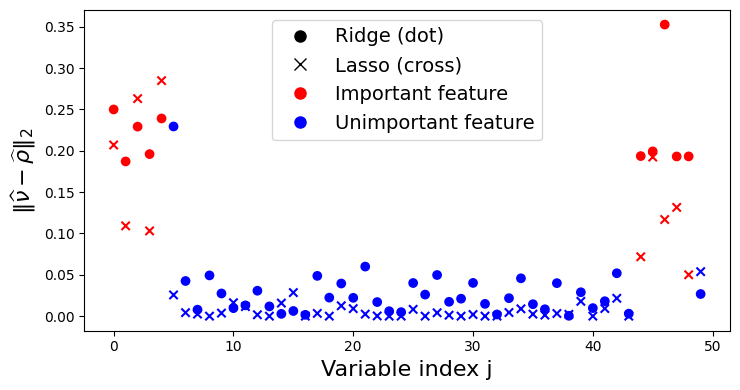

In [7]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
colors = np.where(true_imp == 1, "red", "blue")
plt.figure(figsize=(7.5,4))

# Ridge: dots
plt.scatter(np.arange(d), diff_ridge,
            c=colors, marker='o', label='Ridge')

# Lasso: crosses
plt.scatter(np.arange(d), diff_lasso,
            c=colors, marker='x', label='Lasso')

plt.xlabel("Variable index j", fontsize=16)
plt.ylabel(r"$\|\widehat{\nu} - \widehat{\rho}\|_2$", fontsize=16)
#plt.title("Imputers Differences", fontsize=16)
legend_elements = [
    Line2D([0], [0], marker='o', color='black', linestyle='None', markersize=8,
           label='Ridge (dot)'),
    Line2D([0], [0], marker='x', color='black', linestyle='None', markersize=8,
           label='Lasso (cross)'),
    Line2D([0], [0], marker='o', color='red', linestyle='None', markersize=8,
           label='Important feature'),
    Line2D([0], [0], marker='o', color='blue', linestyle='None', markersize=8,
           label='Unimportant feature'),
]

plt.legend(handles=legend_elements, fontsize=14)
plt.tight_layout()
plt.savefig(f"new_figures/stability_ridge_lasso.pdf", bbox_inches="tight")
plt.show()


### AUC

In [8]:
import os, sys
sys.path.append(os.path.abspath(os.path.join("..", "src")))
from cpi_KO import CPI_KO
from sklearn.linear_model import LassoCV
from sklearn.metrics import roc_auc_score



n_samples = [100, 300, 500, 1000]
rep = 10
sparsity = 0.25
seed = 0
AUC_diff_lasso = np.zeros((len(n_samples), rep))
AUC_diff_ridge = np.zeros((len(n_samples), rep))

n_jobs = 1

for i, n in enumerate(n_samples):
    for j in range(rep):
        seed = j
        d=int(n/3)
        true_imp = np.zeros(d)
        X, y, _, non_zero_index, _ = simu_data(n, d, rho=0.6, sparsity=sparsity, seed=seed)
        true_imp[non_zero_index] = 1
        model = LassoCV(alphas=np.logspace(-3, 3, 10), cv=5, random_state=seed)
        model.fit(X, y)

        cpi_knockoffs= CPI_KO(
                        estimator=model,
                        imputation_model=RidgeCV(alphas=np.logspace(-3, 3, 10), cv=5),
                        imputation_model_y=RidgeCV(alphas=np.logspace(-3, 3, 10), cv=5),
                        random_state=seed,
                        n_jobs=n_jobs)
        cpi_knockoffs.fit(X, y)

        cpi_KO_importance = cpi_knockoffs.score(X, y, n_perm=1,  p_val='wilcox')


        cpi_knockoffs_lasso= CPI_KO(
                        estimator=model,
                        imputation_model=LassoCV(alphas=np.logspace(-3, 3, 10), cv=5),
                        imputation_model_y=LassoCV(alphas=np.logspace(-3, 3, 10), cv=5),
                        random_state=seed,
                        n_jobs=n_jobs)
        cpi_knockoffs_lasso.fit(X, y)

        cpi_KO_importance_lasso = cpi_knockoffs_lasso.score(X, y, n_perm=1,  p_val='wilcox')

        list_X_ridge  = cpi_knockoffs._list_imputation_models
        list_Xy_ridge = cpi_knockoffs._list_imputation_models_y

        list_X_lasso  = cpi_knockoffs_lasso._list_imputation_models
        list_Xy_lasso = cpi_knockoffs_lasso._list_imputation_models_y

        diff_ridge = compute_norm_differences(list_X_ridge, list_Xy_ridge, d)
        diff_lasso = compute_norm_differences(list_X_lasso, list_Xy_lasso, d)
        AUC_diff_lasso[i, j] = roc_auc_score(true_imp, diff_lasso)
        AUC_diff_ridge[i, j] = roc_auc_score(true_imp, diff_ridge)


/home/mind/areyerol/.local/miniconda3/lib/python3.12/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se
/home/mind/areyerol/.local/miniconda3/lib/python3.12/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se
/home/mind/areyerol/.local/miniconda3/lib/python3.12/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se
/home/mind/areyerol/.local/miniconda3/lib/python3.12/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se
/home/mind/areyerol/.local/miniconda3/lib/python3.12/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se
/home/mind/areyerol/.local/miniconda3/lib/python3.12/site-packages/scipy/stats/_wilcoxon.py:172

/tmp/ipykernel_2033261/1224234102.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


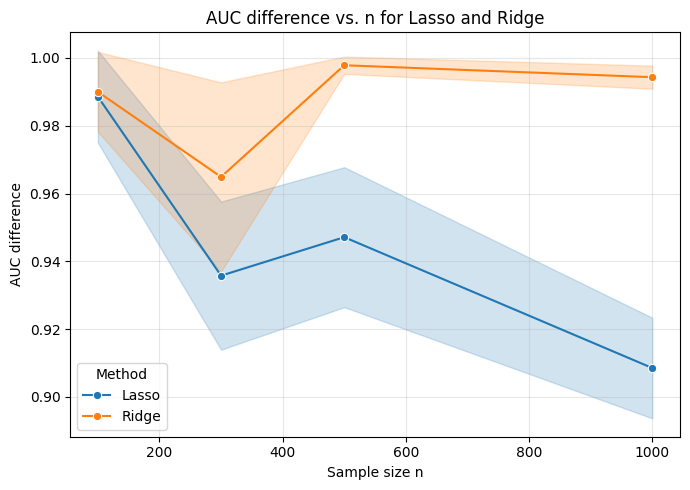

In [9]:
df = []

for i, n in enumerate(n_samples):
    for r in range(rep):
        df.append([n, AUC_diff_lasso[i, r], "Lasso"])
        df.append([n, AUC_diff_ridge[i, r], "Ridge"])

df = pd.DataFrame(df, columns=["n", "AUC_diff", "Method"])

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
sns.lineplot(
    data=df,
    x="n",
    y="AUC_diff",
    hue="Method",
    marker="o",
    ci="sd"   # add shaded standard deviation bands
)

plt.xlabel("Sample size n")
plt.ylabel("AUC difference")
plt.title("AUC difference vs. n for Lasso and Ridge")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Computing FDP

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_importance_points(estimated_importance, true_importance, jitter=0.05, knockoff_threshold=0, fdp=0, power=0, r2=0, new_figure=True):
    """
    Plot estimated importance values as individual points, separated by true importance.

    Parameters
    ----------
    estimated_importance : array-like
        Vector of real-valued estimated importances.
    true_importance : array-like
        Binary vector (0 = unimportant, 1 = important).
    jitter : float, optional
        Random horizontal jitter to avoid overlapping points (default=0.05).
    """

    estimated = np.asarray(estimated_importance).reshape(-1)
    true = np.asarray(true_importance).reshape(-1)

    if len(estimated) != len(true):
        raise ValueError("Both vectors must have the same length")

    # Create x positions (0 or 1) + small jitter to avoid overlap
    x_positions = true + np.random.uniform(-jitter, jitter, size=len(true))

    if new_figure:
        plt.figure(figsize=(5, 5)) 
    plt.scatter(
        x_positions[true == 0],
        estimated[true == 0],
        alpha=0.6,
        label="Unimportant (true=0)",
        color="skyblue",
        edgecolor="k",
        s=60,
    )
    plt.scatter(
        x_positions[true == 1],
        estimated[true == 1],
        alpha=0.6,
        label="Important (true=1)",
        color="salmon",
        edgecolor="k",
        s=60,
    )

    plt.xticks([0, 1], ["Unimportant", "Important"])
    plt.ylabel("Estimated Importance")
    plt.title("Estimated Importance by True Feature Class")
    #plt.legend()
    plt.axhline(y=0, color='black', linestyle='--', label='Threshold')
    plt.axhline(y=knockoff_threshold, color='red', linestyle='--', label='Threshold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    if new_figure:
        plt.xlabel(f"FDP={fdp:.2f}, Power={power:.2f}, R2={r2:.2f}")
        plt.show()



In [11]:
fdr = 0.2
ko_thr = knockoff_threshold(cpi_KO_importance["importance"].reshape((d,)), fdr=fdr)
selected = np.where(cpi_KO_importance["importance"].reshape((d,)) >= ko_thr)[0]
from hidimstat.statistical_tools.multiple_testing import fdp_power
fdp, power = fdp_power(selected, non_zero_index.flatten())

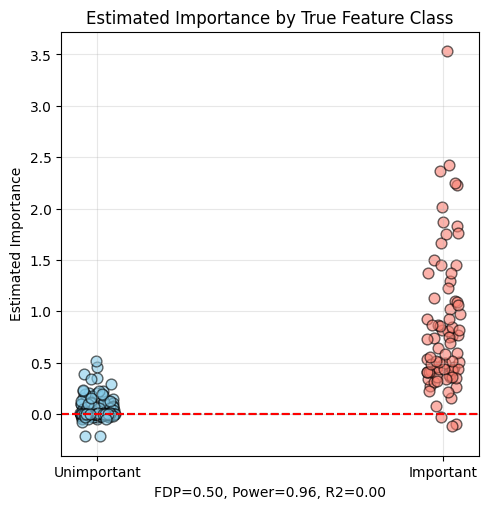

In [12]:
plot_importance_points(cpi_KO_importance["importance"].reshape((d,)), true_imp, knockoff_threshold=ko_thr, fdp=fdp, power=power)

In [13]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

regressors = {
    "Lasso": LassoCV(alphas=np.logspace(-3, 3, 10), cv=5, random_state=seed),
    "Ridge": RidgeCV(alphas=np.logspace(-3, 3, 10), cv=5),
    "Random Forest": RandomForestRegressor(n_estimators=300, random_state=seed),
    "Gradient Boosting": GradientBoostingRegressor(random_state=seed),
    "Neural Net": MLPRegressor(hidden_layer_sizes=(50,50),
                               max_iter=2000, random_state=seed)
}


results = {}

n = 300
d = 50
sparsity = 0.25
seed = 0

n_jobs = 1


true_imp = np.zeros(d)
X, y, _, non_zero_index, _ = simu_data(n, d, rho=0.6, sparsity=sparsity, seed=seed)
true_imp[non_zero_index] = 1
for name, reg in regressors.items():
    print(f"Running CPI_KO with {name}...")

    reg.fit(X, y)
    cpi = CPI_KO(
        estimator=reg,
        imputation_model=RidgeCV(alphas=np.logspace(-3, 3, 10), cv=5),
        imputation_model_y=RidgeCV(alphas=np.logspace(-3, 3, 10), cv=5),
        random_state=seed,
        n_jobs=n_jobs
    )

    cpi.fit(X, y)
    importance = cpi.score(X, y, n_perm=1, p_val="wilcox")["importance"].reshape(d)

    # Knockoff threshold
    fdr = 0.2
    thr = knockoff_threshold(importance, fdr=fdr)
    selected = np.where(importance >= thr)[0]

    # FDP & Power
    from hidimstat.statistical_tools.multiple_testing import fdp_power
    fdp, power = fdp_power(selected, non_zero_index.flatten())

    results[name] = {
        "importance": importance,
        "threshold": thr,
        "fdp": fdp,
        "power": power,
    }


Running CPI_KO with Lasso...


/home/mind/areyerol/.local/miniconda3/lib/python3.12/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se


Running CPI_KO with Ridge...
Running CPI_KO with Random Forest...
Running CPI_KO with Gradient Boosting...
Running CPI_KO with Neural Net...


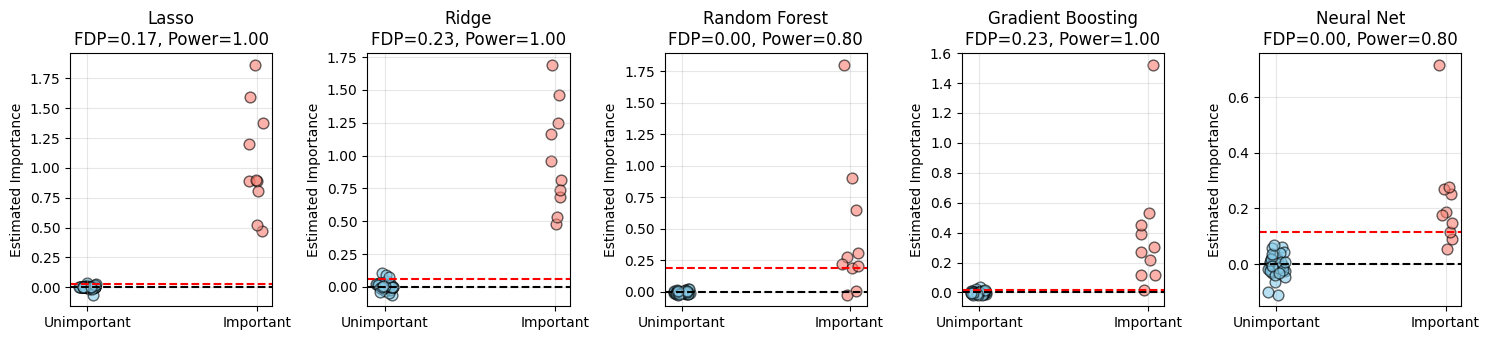

In [14]:
cols = len(results)
fig, axes = plt.subplots(1, cols, figsize=(3 * cols, 3.5))

for ax, (name, res) in zip(axes, results.items()):
    plt.sca(ax)  # set current axis
    
    plot_importance_points(
        res["importance"],
        true_imp,
        jitter=0.05,
        knockoff_threshold=res["threshold"],
        fdp=res["fdp"],
        power=res["power"],
        new_figure=False   
    )
    ax.set_title(f"{name}\nFDP={res['fdp']:.2f}, Power={res['power']:.2f}")

plt.tight_layout()
plt.savefig(f"new_figures/fdp_illustration.pdf", bbox_inches="tight")
plt.show()


In [15]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

regressors = {
    "Lasso": LassoCV(alphas=np.logspace(-3, 3, 10), cv=5, random_state=seed),
    "Ridge": RidgeCV(alphas=np.logspace(-3, 3, 10), cv=5),
    "Random Forest": RandomForestRegressor(n_estimators=300, random_state=seed),
    "Gradient Boosting": GradientBoostingRegressor(random_state=seed),
    "Neural Net": MLPRegressor(hidden_layer_sizes=(50,50),
                               max_iter=2000, random_state=seed)
}


results = {}

n_test = 0 # Only to compute the R2, not used
n = 300
d = 50
sparsity = 0.25
seed = 0

n_jobs = 1


true_imp = np.zeros(d)
X, y, _, non_zero_index, _ = simu_data(n+n_test, d, rho=0.6, sparsity=sparsity, seed=seed)
true_imp[non_zero_index] = 1
X_test, y_test = X[n:], y[n:]
X, y = X[:n], y[:n]
for name, reg in regressors.items():
    print(f"Running CPI_KO with {name}...")

    reg.fit(X, y)
    #r2 = reg.score(X_test, y_test)
    r2 = reg.score(X, y)
    cpi = CPI_KO(
        estimator=reg,
        imputation_model=RidgeCV(alphas=np.logspace(-3, 3, 10), cv=5),
        imputation_model_y=RidgeCV(alphas=np.logspace(-3, 3, 10), cv=5),
        random_state=seed,
        n_jobs=n_jobs
    )

    cpi.fit(X, y)
    importance = cpi.score(X, y, n_perm=1, p_val="wilcox")["importance"].reshape(d)

    # Knockoff threshold
    fdr = 0.2
    thr = knockoff_threshold(importance, fdr=fdr)
    selected = np.where(importance >= thr)[0]

    # FDP & Power
    from hidimstat.statistical_tools.multiple_testing import fdp_power
    fdp, power = fdp_power(selected, non_zero_index.flatten())

    results[name] = {
        "importance": importance,
        "threshold": thr,
        "fdp": fdp,
        "power": power,
        "r2": r2,
    }


Running CPI_KO with Lasso...


/home/mind/areyerol/.local/miniconda3/lib/python3.12/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se


Running CPI_KO with Ridge...
Running CPI_KO with Random Forest...
Running CPI_KO with Gradient Boosting...


/home/mind/areyerol/.local/miniconda3/lib/python3.12/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se


Running CPI_KO with Neural Net...


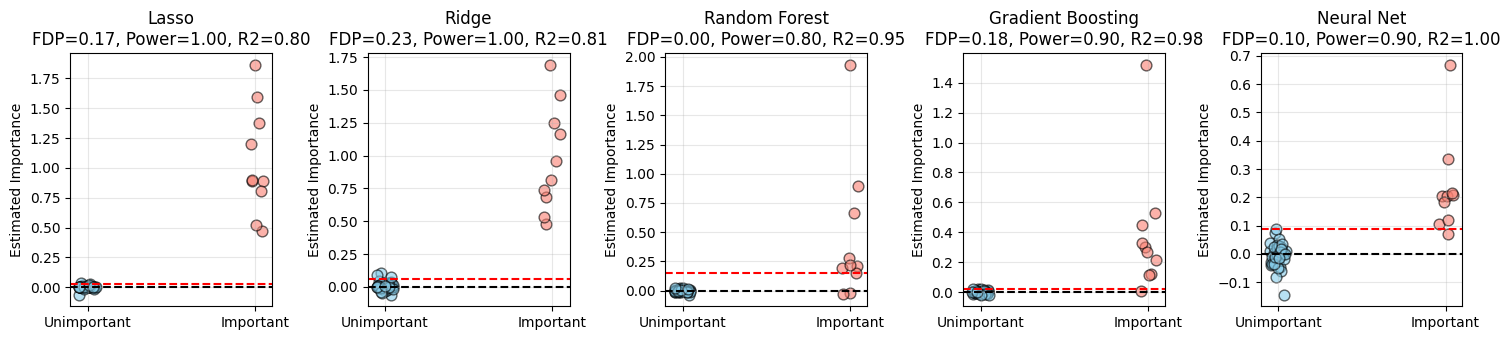

In [16]:
cols = len(results)
fig, axes = plt.subplots(1, cols, figsize=(3 * cols, 3.5))

for ax, (name, res) in zip(axes, results.items()):
    plt.sca(ax)  # set current axis
    
    plot_importance_points(
        res["importance"],
        true_imp,
        jitter=0.05,
        knockoff_threshold=res["threshold"],
        fdp=res["fdp"],
        power=res["power"],
        r2=res["r2"],
        new_figure=False   
    )
    ax.set_title(f"{name}\nFDP={res['fdp']:.2f}, Power={res['power']:.2f}, R2={res['r2']:.2f}")

plt.tight_layout()
plt.savefig(f"new_figures/fdp_illustration.pdf", bbox_inches="tight")
plt.show()
